In [1]:
import gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time

from collections import deque

In [2]:
GAMMA = 0.99
LEARNING_RATE = 0.01
TARGET_UPDATE = 10

n_episodes = 100000
hidden_dim = 12
min_eps = 0.01
max_eps_episode = 50

### NN - Q Network

In [3]:
import torch.nn as nn

class QNN(nn.Module):
    def __init__(self, ip_dim, op_dim, hid_dim) -> None:
        
        super(QNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(ip_dim, hid_dim),
            torch.nn.PReLU()
        )

        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(hid_dim, hid_dim),
            torch.nn.PReLU()
        )

        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(hid_dim, hid_dim),
            torch.nn.PReLU()
        )
        
        self.final = torch.nn.Linear(hid_dim, op_dim)
        
    def forward(self, t: torch.Tensor) -> torch.Tensor:
        t = self.layer1(t)
        t = self.layer2(t)
        t = self.layer3(t)
        t = self.final(t)

        return t
        

        

## relay memory

reference: https://docs.python.org/3/library/collections.html#collections.namedtuple

In [4]:
import random
from collections import namedtuple

transition = namedtuple('transition',('state', 'action', 'reward','nxt_state','stop'))

class ReplayMemory_CyclicBuffer(object):
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) 
            
    def __len__(self):
        return len(self.memory)
        
    def push_to_memory(self, *args):
        self.memory.append(transition(*args))
        
    def random_sampling(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    
# test = transition(((1,2),(2,3),(4,5)),('stay','left','right'),(1,1,1),((4,5),(6,7),(8,9)))
# print(test)
    

## Agent

In [5]:
import torch.optim as optim

from torch.autograd import Variable

BATCH_SIZE = 64
FloatTensor = torch.FloatTensor #32-bit float multi dimension matrix

class Agent_MountainCart(object):
    
    def __init__(self, n_states, n_actions, hidden_dim, learning_rate):
        self.device = torch.device("cpu")
        self.local_q = QNN(n_states, n_actions, hidden_dim).to(self.device)
        self.target_q = QNN(n_states, n_actions, hidden_dim).to(self.device)
        
        self.mse_loss = torch.nn.MSELoss()
        self.optim = optim.Adam(self.local_q.parameters(), lr=learning_rate)
        
        self.n_states = n_states
        self.n_actions = n_actions
        
        self.replay_memory = ReplayMemory_CyclicBuffer(10000)
        
        
    def get_action(self, state, eps_greedy, eps_flag = True):
        global steps_done
        
        random_sample = random.random()
        
        if random_sample > eps_greedy:
            with torch.no_grad():
                return self.local_q((state).type(FloatTensor)).data.max(1)[1].view(1,1)
        else:
            return torch.tensor([[random.randrange(self.n_actions)]])
        
    def learn(self, experience, GAMMA):
        
        if len(self.replay_memory.memory) < BATCH_SIZE:
            return;
        
        transitions_sample = self.replay_memory.random_sampling(BATCH_SIZE)
        batch = transition(*zip(*transitions_sample))
        
        states = torch.cat(batch.state)
        actions = torch.cat(batch.action)
        rewards = torch.cat(batch.reward)
        nxt_states = torch.cat(batch.nxt_state)
        stops = torch.cat(batch.stop)
        
        expected_Q = torch.gather(self.local_q(states),1,actions)
        nxt_targets_Q = self.target_q(nxt_states).detach().max(1)[0]
        targets_Q = rewards + (GAMMA * nxt_targets_Q * (1-stops)) #1-dones
        self.local_q.train(mode = True)
        self.optim.zero_grad()
        loss = self.mse_loss(expected_Q, targets_Q.unsqueeze(1))
        loss.backward()
        self.optim.step()
        

In [6]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [7]:


env = gym.make('MountainCar-v0')

dim_space = env.observation_space.shape[0]
dim_action = env.action_space.n

threshold = env.spec.reward_threshold

print('ip_dim:', dim_space, 'op_dim:', dim_action,'hidden_dim:',hidden_dim,'threshold:', threshold)

agent = Agent_MountainCart(dim_space, dim_action, hidden_dim, learning_rate=LEARNING_RATE)

def epsilon_annealing(i_episode, max_episode, min_eps: float):
    
    slope = (min_eps - 1.0)/max_episode
    max_eps = max(slope * i_episode + 1.0, min_eps)
    return max_eps

def save_q(directory, filename):
    torch.save(agent.local_q.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.target_q.state_dict(), '%s/%s_target.pth' % (directory, filename))

    
    

ip_dim: 2 op_dim: 3 hidden_dim: 12 threshold: -110.0


In [8]:
def play_episode(env, agent, eps):
    
    state = env.reset()
    stop = False
    total_reward = 0
    
    while not stop:
        action = agent.get_action(FloatTensor([state]), eps)
        nxt_state, reward, stop, _ = env.step(action.item())
        total_reward = total_reward + reward
        
        if stop:
            reward = -1
            
        agent.replay_memory.push_to_memory(
            FloatTensor([state]),
             action,
             FloatTensor([reward]),
             FloatTensor([nxt_state]),
             FloatTensor([stop])
        )
        
        if(len(agent.replay_memory) > BATCH_SIZE):
            batch = agent.replay_memory.random_sampling(BATCH_SIZE)
            agent.learn(batch, GAMMA)
            
        state = nxt_state
        
    return total_reward

In [9]:
def train():
    scores = deque(maxlen=100)
    temp_scores = []
    avg_scores = []
    
    start_time = time.time()
    
    for i_episode in range(n_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = play_episode(env, agent, eps)
        
        scores.append(score)
        temp_scores.append(score)
        
        avg_score = np.mean(scores)
        avg_scores.append(avg_score)
        
        dt = (int)(time.time() - start_time)
        
        if i_episode % 10 == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.3f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))
            
        if len(scores) == 100 and  avg_score >= threshold: 
                print('\n MountainCart solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores)))
                break
                
        if i_episode % TARGET_UPDATE == 0:
            agent.target_q.load_state_dict(agent.local_q.state_dict()) 
                
    return temp_scores, avg_scores

scores, avg_scores = train()
save_q('gym_agents','MountainCar')
            

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


Episode:    10 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.802 Time: 00:00:08
Episode:    20 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.604 Time: 00:00:14
Episode:    30 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.406 Time: 00:00:19
Episode:    40 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.208 Time: 00:00:27
Episode:    50 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:00:34
Episode:    60 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:00:47
Episode:    70 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:00:59
Episode:    80 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:01:12
Episode:    90 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:01:27
Episode:   100 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:01:33
Episode:   110 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:01:39
Episode:   120 Score: -200.0  Avg.Score: -200.00, eps-greedy: 0.010 Time: 00:01:47
Epis

Episode:  1000 Score: -114.0  Avg.Score: -122.48, eps-greedy: 0.010 Time: 00:12:31
Episode:  1010 Score: -105.0  Avg.Score: -121.99, eps-greedy: 0.010 Time: 00:12:37
Episode:  1020 Score: -113.0  Avg.Score: -121.24, eps-greedy: 0.010 Time: 00:12:44
Episode:  1030 Score: -113.0  Avg.Score: -122.48, eps-greedy: 0.010 Time: 00:12:52
Episode:  1040 Score: -116.0  Avg.Score: -124.38, eps-greedy: 0.010 Time: 00:12:57
Episode:  1050 Score: -173.0  Avg.Score: -124.76, eps-greedy: 0.010 Time: 00:13:09
Episode:  1060 Score: -200.0  Avg.Score: -130.17, eps-greedy: 0.010 Time: 00:13:23
Episode:  1070 Score: -200.0  Avg.Score: -134.31, eps-greedy: 0.010 Time: 00:13:29
Episode:  1080 Score: -87.0  Avg.Score: -135.28, eps-greedy: 0.010 Time: 00:13:35
Episode:  1090 Score: -156.0  Avg.Score: -137.44, eps-greedy: 0.010 Time: 00:13:41
Episode:  1100 Score: -132.0  Avg.Score: -140.16, eps-greedy: 0.010 Time: 00:13:47
Episode:  1110 Score: -129.0  Avg.Score: -140.08, eps-greedy: 0.010 Time: 00:13:51
Episo

In [ ]:
scores_iteration_2, avg_scores_iteration_2 = train()
# save_q('gym_agents','MountainCar')

In [ ]:
scores_iteration_3, avg_scores_iteration_3 = train()
# save_q('gym_agents','MountainCar')

scores length:  1641 , avg_scores length:  1641


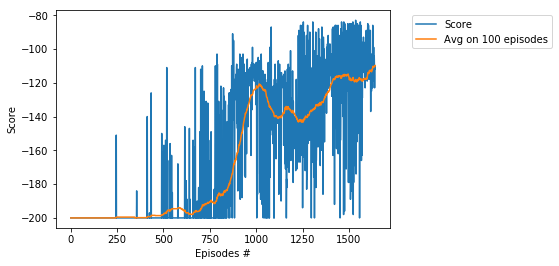

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

print('scores length: ', len(scores), ', avg_scores length: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

## Watch Agent

In [11]:
def play_agent(env, agent, n_episodes):
    state = env.reset()
    scores = deque(maxlen=100)
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()        
        
        total_reward = 0
        start_time = time.time()
        timesteps =  0
        
        while True:
            
            a = agent.get_action(FloatTensor([state]), eps_flag=False, eps_greedy=0.01)
            env.render()
            nxt_state, r, done, _ = env.step(a.item())
            state = nxt_state
            total_reward += r
            timesteps += 1
            
            if done:
                break 

        delta = (int)(time.time() - start_time) 
        
        scores.append(total_reward)

        print('Episode {}\tAverage Score: {:.2f}, \t Timesteps: {} \tTime: {:02}:{:02}:{:02}'\
                  .format(i_episode, np.mean(scores), timesteps,\
                          delta//3600, delta%3600//60, delta%60))
        
def load(agent, directory, filename):
    agent.local_q.load_state_dict(torch.load('%s/%s_local.pth' % (directory,  filename)))
    agent.target_q.load_state_dict(torch.load('%s/%s_target.pth' % (directory,  filename)))


In [12]:
load(agent, 'gym_agents', 'MountainCar')
play_agent(env=env, agent=agent, n_episodes=10)

Episode 1	Average Score: -113.00, 	 Timesteps: 113 	Time: 00:00:07
Episode 2	Average Score: -115.00, 	 Timesteps: 117 	Time: 00:00:02
Episode 3	Average Score: -108.33, 	 Timesteps: 95 	Time: 00:00:01
Episode 4	Average Score: -112.50, 	 Timesteps: 125 	Time: 00:00:02
Episode 5	Average Score: -107.80, 	 Timesteps: 89 	Time: 00:00:01
Episode 6	Average Score: -108.83, 	 Timesteps: 114 	Time: 00:00:01
Episode 7	Average Score: -109.57, 	 Timesteps: 114 	Time: 00:00:02
Episode 8	Average Score: -110.25, 	 Timesteps: 115 	Time: 00:00:01
Episode 9	Average Score: -110.56, 	 Timesteps: 113 	Time: 00:00:00
Episode 10	Average Score: -110.80, 	 Timesteps: 113 	Time: 00:00:00


In [14]:
env.close()